<a href="https://colab.research.google.com/github/Shafqatsarwar/Google_colab_langchain_gemini/blob/main/2nd_Langgraph_Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Research Assistant

Now, we'll bring all ideas together to tackle one of AI's most popular applications: research automation.

Research demands customization: raw LLM outputs are often poorly suited for real-world decision-making workflows.

Customized, AI-based research and report generation workflows are a promising way to address this.

Goal:

Our goal is to build a lightweight, multi-agent system around chat models that customizes the research process.

Source Selection:

Users can choose any set of input sources for their research.

Planning:

Users provide a topic, and the system generates a team of AI analysts, each focusing on one sub-topic.

 * Human-in-the-loop

 Will be used to refine these sub-topics before research begins.
 * LLM Utilization

 Each analyst will conduct in-depth search with an expert AI using the selected sources.
 * Research Process

 Experts will gather information to answer analyst questions in parallel.
And all searchs will be conducted simultaneously through map-reduce.
Output Format

We'll use customizable prompts for the report, allowing for a flexible output format.

In [2]:
%pip install --quiet -U langgraph langchain langchain_openai langchain_community langchain_core tavily-python wikipedia
# %pip install -q -U langchain-google-genai
%pip install httpx==0.27.2

# Setup

In [3]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

OPENAI_API_KEY: ··········


In [13]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [4]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"


LANGCHAIN_API_KEY: ··········


Generat Analyst: Human-in-the-loop

In [8]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

set Analyst main instructions

In [14]:
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}

2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts:

{human_analyst_feedback}

3. Determine the most interesting themes based upon documents and / or feedback above.

4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

def create_analysts(state: GenerateAnalystsState):

    """ Create analysts """

    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')

    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(topic=topic,
                                                            human_analyst_feedback=human_analyst_feedback,
                                                            max_analysts=max_analysts)

    # Generate question
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])

    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"

    # Otherwise end
    return END


Logic/ Add nodes and edges

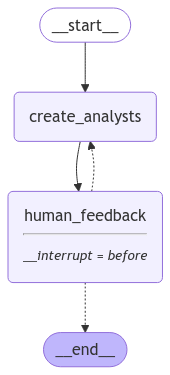

In [15]:
from IPython.display import Image, display

# Add nodes and edges
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [16]:
# Input
max_analysts = 3
topic = "The benefits of adopting imported used cars in Pakistan"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Ayesha Khan
Affiliation: Pakistan Automotive Manufacturers Association
Role: Local Automotive Industry Advocate
Description: Ayesha is focused on the impact of imported used cars on the local automotive industry. She is concerned about how these imports might affect local manufacturers and the overall economy. Her motive is to ensure that the local industry remains competitive and sustainable.
--------------------------------------------------
Name: Dr. Imran Ali
Affiliation: Pakistan Environmental Protection Agency
Role: Environmental Impact Analyst
Description: Dr. Imran is interested in the environmental implications of importing used cars. He is concerned about the potential increase in emissions and waste management issues. His motive is to promote environmentally friendly policies and practices in the automotive sector.
--------------------------------------------------
Name: Sara Ahmed
Affiliation: Consumer Rights Commission of Pakistan
Role: Consumer Advocate
Description:

In [17]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [18]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback":
                            "Add in someone from a startup to add an entrepreneur perspective"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efb769b-36eb-6f21-8002-2ba4cba20870'}}

In [19]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Ayesha Khan
Affiliation: Pakistan Automotive Manufacturers Association
Role: Local Automotive Industry Advocate
Description: Ayesha is focused on the impact of imported used cars on the local automotive industry. She is concerned about how these imports might affect local manufacturers and the overall economy. Her motive is to ensure that the local industry remains competitive and sustainable.
--------------------------------------------------
Name: Dr. Imran Ali
Affiliation: Pakistan Environmental Protection Agency
Role: Environmental Impact Analyst
Description: Dr. Imran is interested in the environmental implications of importing used cars. He is concerned about the potential increase in emissions and waste management issues. His motive is to promote environmentally friendly policies and practices in the automotive sector.
--------------------------------------------------
Name: Sara Ahmed
Affiliation: Consumer Rights Commission of Pakistan
Role: Consumer Advocate
Description:

In [20]:
# If we are satisfied, then we simply supply no feedback
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback":
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efb769d-6419-6d56-8004-a9465edd7f1d'}}

In [22]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [23]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [24]:
final_state.next

()

In [25]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50)

Name: Ayesha Khan
Affiliation: Pakistani Automotive Association
Role: Industry Expert
Description: Ayesha focuses on the automotive industry's growth and sustainability. She is concerned with how imported used cars can impact local manufacturing and employment, and she advocates for policies that balance these interests.
--------------------------------------------------
Name: Dr. Imran Ali
Affiliation: Pakistani Environmental Agency
Role: Environmental Analyst
Description: Dr. Imran is dedicated to understanding the environmental implications of automotive imports. He evaluates the carbon footprint and pollution levels associated with used cars and promotes eco-friendly transportation solutions.
--------------------------------------------------
Name: Sara Ahmed
Affiliation: AutoTech Startup
Role: Entrepreneur
Description: Sara brings an entrepreneurial perspective, exploring how imported used cars can create business opportunities in the automotive tech sector. She is interested in i

Now, we create nodes to search the web and wikipedia.

We'll also create a node to answer analyst questions.

Finally, we'll create nodes to save the full conversation and to write a summary ("section") of the conversation.

In [26]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("TAVILY_API_KEY")

TAVILY_API_KEY: ··········


In [27]:
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

In [28]:
# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

In [30]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class SearchState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    search: str # search transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [32]:
from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert.

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.

First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def search_web(state: SearchState):

    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])

    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

def search_wikipedia(state: SearchState):

    """ Retrieve docs from wikipedia """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])

    # Search
    search_docs = WikipediaLoader(query=search_query.search_query,
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

answer_instructions = """You are an expert being searched by an analyst.

Here is analyst area of focus: {goals}.

You goal is to answer a question posed by the researcher.

To answer question, use this context:

{context}

When answering questions, follow these guidelines:

1. Use only the information provided in the context.

2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1].

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc

6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list:

[1] assistant/docs/llama3_1.pdf, page 7

And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: SearchState):

    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)

    # Name the message as coming from the expert
    answer.name = "expert"

    # Append it to state
    return {"messages": [answer]}

def save_search(state: SearchState):

    """ Save searchs """

    # Get messages
    messages = state["messages"]

    # Convert search to a string
    search = get_buffer_string(messages)

    # Save to searchs key
    return {"search": search}

def route_messages(state: SearchState,
                   name: str = "expert"):

    """ Route between question and answer """

    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_search'

    # This router is run after each question - answer pair
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]

    if "Thank you so much for your help" in last_question.content:
        return 'save_search'
    return "ask_question"

section_writer_instructions = """You are an expert technical writer.

Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents:
- The name of each source document is at the start of the document, with the <Document tag.

2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers

3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst:
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the search
- Create a numbered list of source documents, as you use them
- Do not mention the names of researcher or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents

6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/

8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: SearchState):

    """ Node to answer a question """

    # Get state
    search = state["search"]
    context = state["context"]
    analyst = state["analyst"]

    # Write section using either the gathered source docs from search (context) or the search itself (search)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")])

    # Append it to state
    return {"sections": [section.content]}


In [34]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic.

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.

2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}

Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.

When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: SearchState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)

    # Write messages to state
    return {"messages": [question]}

Builg graph logic nodes and edge

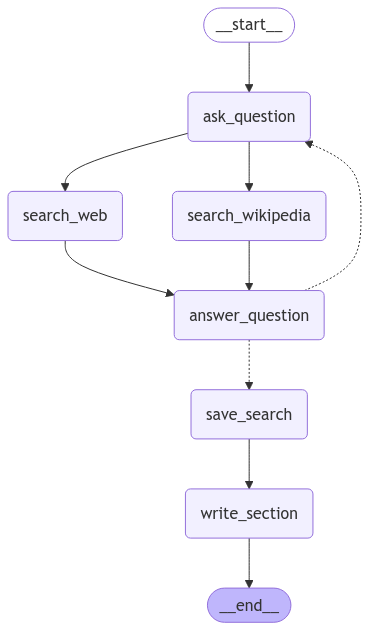

In [35]:
# Add nodes and edges
search_builder = StateGraph(SearchState)
search_builder.add_node("ask_question", generate_question)
search_builder.add_node("search_web", search_web)
search_builder.add_node("search_wikipedia", search_wikipedia)
search_builder.add_node("answer_question", generate_answer)
search_builder.add_node("save_search", save_search)
search_builder.add_node("write_section", write_section)

# Flow
search_builder.add_edge(START, "ask_question")
search_builder.add_edge("ask_question", "search_web")
search_builder.add_edge("ask_question", "search_wikipedia")
search_builder.add_edge("search_web", "answer_question")
search_builder.add_edge("search_wikipedia", "answer_question")
search_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_search'])
search_builder.add_edge("save_search", "write_section")
search_builder.add_edge("write_section", END)

# search
memory = MemorySaver()
search_graph = search_builder.compile(checkpointer=memory).with_config(run_name="Conduct Search")

# View
display(Image(search_graph.get_graph().draw_mermaid_png()))

In [ ]:
# Pick one analyst
analysts[0]

# Test our graph now

In [36]:
from IPython.display import Markdown
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = search_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

## Balancing Growth and Sustainability in Pakistan's Automotive Industry

### Summary

The automotive industry in Pakistan is currently facing significant challenges due to the surge in imports of used cars. This trend is impacting local manufacturing and employment, raising concerns about the sustainability of the industry. The influx of imported used vehicles has been exacerbated by the government's decision to eliminate protective taxes, which previously shielded the local industry from such competition [1]. This policy change has led to a staggering 684% increase in the import of used cars in the first half of the fiscal year, severely affecting local manufacturers [2].

The local automotive industry, a crucial contributor to job creation and government revenue, is struggling to maintain its footing amidst these challenges. Major Original Equipment Manufacturers (OEMs) like Indus Motor Company, Honda Car, and Suzuki Motors have been forced to halt production due to low demand, highlighting the dire situation [3]. The industry is calling for government intervention to stem the influx of imported cars and protect local jobs and manufacturing capabilities [4].

This situation in Pakistan mirrors historical challenges faced by other countries, such as India, which implemented protective measures in the past to foster local manufacturing. India's automotive industry, now the third-largest automobile market in the world, benefited from policies that restricted imports and encouraged local production [5]. Similarly, South Africa's automotive industry has thrived by leveraging trade agreements and maintaining a balance between local production and imports [6].

The current scenario in Pakistan presents a complex challenge: balancing the benefits of open markets with the need to protect local industries. The surge in used car imports offers consumers more affordable options but threatens the viability of local manufacturers and the jobs they provide. Policymakers must consider strategies that support local manufacturing while addressing consumer needs, potentially through incentives for local production or revised import policies.

In conclusion, the Pakistani automotive industry is at a crossroads. The government and industry stakeholders must collaborate to develop policies that ensure sustainable growth, protect local jobs, and maintain the industry's contribution to the economy. This balance is crucial for the long-term health of the automotive sector and the broader economic landscape in Pakistan.

### Sources
[1] https://propakistani.pk/2024/03/26/increasing-used-car-imports-are-pressuring-pakistans-auto-industry-pama/  
[2] https://www.pakwheels.com/blog/increase-in-import-of-used-cars-triggers-alarm/  
[3] https://www.brecorder.com/news/40262281  
[4] https://www.thenews.com.pk/print/1189073-local-auto-industry-seeks-govt-help-to-stem-imported-cars-influx  
[5] https://en.wikipedia.org/wiki/Automotive_industry_in_India  
[6] https://en.wikipedia.org/wiki/Automotive_industry_in_South_Africa  

# Parallelze Searchs: Map-Reduce

We parallelize the Search via the `Send()` API, a map step.

We combine them into the report body in a reduce step.

 * Finalize

 We add a final step to write an intro and conclusion to the final report.

In [70]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

In [71]:
from langgraph.constants import Send

report_writer_instructions = """You are a technical writer creating a report on this overall topic:

{topic}

You have a team of analysts. Each analyst has done two things:

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task:

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos.
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:

1. Use markdown formatting.
2. Include no pre-amble for the report.
3. Use no sub-heading.
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from:

{context}"""

def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")])
    return {"content": report.content}

intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting.

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header.

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report

    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")])
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report

    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")])
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

In [73]:
# Inputs
max_analysts = 2
topic = "The benefits of adopting Electric cars in future"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts},
                          thread,
                          stream_mode="values"):

    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Emily Carter
Affiliation: International Energy Agency
Role: Energy Policy Analyst
Description: Dr. Carter focuses on the global energy transition and the role of electric vehicles in reducing carbon emissions. She is concerned with policy frameworks that support sustainable energy solutions and the economic implications of widespread electric car adoption.
--------------------------------------------------
Name: Mr. John Smith
Affiliation: Tesla, Inc.
Role: Automotive Industry Expert
Description: Mr. Smith is an expert in electric vehicle technology and market trends. He is interested in the technological advancements in electric cars, their impact on the automotive industry, and the potential for innovation in battery technology.
--------------------------------------------------
Name: Prof. Lisa Nguyen
Affiliation: University of California, Berkeley
Role: Environmental Economist
Description: Prof. Nguyen studies the environmental and economic benefits of electric vehicles. 

In [74]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback":
                                "Add in the CEO of Electric cars starts from Japan"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efb7701-fccf-6713-802a-7db64e201b46'}}

In [67]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Emily Carter
Affiliation: International Energy Agency
Role: Energy Policy Analyst
Description: Dr. Carter focuses on the global energy transition and the role of electric vehicles in reducing carbon emissions. She is concerned with policy frameworks that support sustainable energy adoption and the long-term environmental benefits of electric cars.
--------------------------------------------------
Name: Mr. John Smith
Affiliation: Tesla, Inc.
Role: Automotive Industry Expert
Description: Mr. Smith is an expert in the automotive industry with a focus on electric vehicle technology and market trends. He is interested in the technological advancements and economic benefits of electric cars, including cost savings and innovation in battery technology.
--------------------------------------------------
Name: Prof. Lisa Nguyen
Affiliation: University of California, Berkeley
Role: Urban Planning and Transportation Researcher
Description: Prof. Nguyen researches the impact of electri

In [75]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback":
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efb7702-52cd-68d9-802b-ccc3a3527def'}}

In [76]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

<IPython.core.display.Markdown object>